In [9]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

file_path = '/Users/gali/Desktop/dsmp-2024-group15/Python files/LSTM/SARIMAX_bids.csv'
bid = pd.read_csv(file_path)
print(bid)
#bid = bid[:300]
bid['adjusted_time_hours'] = pd.to_timedelta(bid['adjusted_time_hours'], unit='h')
start_date = pd.to_datetime('2025-01-01')
bid['datetime'] = start_date + bid['adjusted_time_hours']
bid.set_index('datetime', inplace=True)
bid = bid.drop('adjusted_time_hours',axis = 1)
bid = bid.drop('Type',axis = 1)
print(bid)




     Type  adjusted_time_hours       Price
0     bid                  0.0  266.722830
1     bid                  1.0  274.188377
2     bid                  2.0  291.270270
3     bid                  3.0  299.853465
4     bid                  4.0  300.404878
...   ...                  ...         ...
1058  bid               1058.0  112.153687
1059  bid               1059.0  112.332262
1060  bid               1060.0  110.633039
1061  bid               1061.0  111.269440
1062  bid               1062.0  110.420057

[1063 rows x 3 columns]
                          Price
datetime                       
2025-01-01 00:00:00  266.722830
2025-01-01 01:00:00  274.188377
2025-01-01 02:00:00  291.270270
2025-01-01 03:00:00  299.853465
2025-01-01 04:00:00  300.404878
...                         ...
2025-02-14 02:00:00  112.153687
2025-02-14 03:00:00  112.332262
2025-02-14 04:00:00  110.633039
2025-02-14 05:00:00  111.269440
2025-02-14 06:00:00  110.420057

[1063 rows x 1 columns]


Testing original data:
Apred Statistic: -3.905159
p-value: 0.001997
Critical Values:
	1%: -3.453
	5%: -2.871
	10%: -2.572
datetime
2025-01-01 01:00:00    -1.136051
2025-01-01 02:00:00     8.904853
2025-01-01 03:00:00    13.348884
2025-01-01 04:00:00     3.749966
2025-01-01 05:00:00    -5.434691
                         ...    
2025-01-13 07:00:00    -1.918669
2025-01-13 08:00:00    -8.782158
2025-01-13 09:00:00    -3.790211
2025-01-13 10:00:00     0.566307
2025-01-13 11:00:00    -4.156854
Name: Price, Length: 299, dtype: float64

Determining the differencing order needed for stationarity:
datetime
2025-01-01 01:00:00    -1.136051
2025-01-01 02:00:00     8.904853
2025-01-01 03:00:00    13.348884
2025-01-01 04:00:00     3.749966
2025-01-01 05:00:00    -5.434691
                         ...    
2025-01-13 07:00:00    -1.918669
2025-01-13 08:00:00    -8.782158
2025-01-13 09:00:00    -3.790211
2025-01-13 10:00:00     0.566307
2025-01-13 11:00:00    -4.156854
Name: Price, Length: 299, dtype:

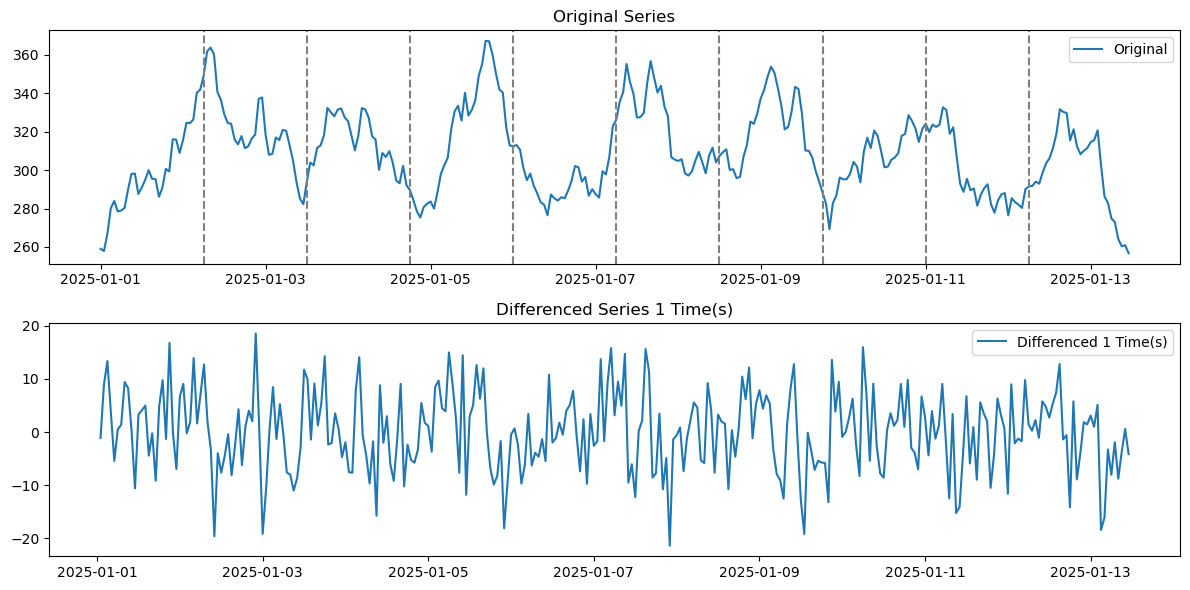

In [9]:
def apred_test(time_series):
    """Perform Apred test and return results"""
    result = adfuller(time_series, autolag='AIC')  # Apred test
    print('Apred Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    return result

def determine_diff_order(timeseries, max_diff=5):
    """Apply iterative differencing and Apred test to determine the order of differencing"""
    p_value = 1
    diff_order = 1
    while p_value > 0.05 and diff_order <= max_diff:
        diff_series = timeseries.diff(periods=diff_order).dropna()
        print(diff_series)
        print(f"\nDifferencing Order: {diff_order}")
        result = apred_test(diff_series)
        p_value = result[1]
        if p_value < 0.05:
            print("Series is stationary")
            break
        diff_order += 1
    return diff_order

# Check original data's stationarity
print("Testing original data:")
apred_test(bid.Price)
bid_diff = bid.Price.diff().dropna()
print(bid_diff)

# Determine the order of differencing needed
print("\nDetermining the differencing order needed for stationarity:")
order = determine_diff_order(bid.Price)

# Plot original and differenced data
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(bid.Price, label='Original')
plt.title('Original Series')
data_points = len(bid.Price)
plt.legend()
interval_hours = 30
start_date = bid.index[0]
end_date = bid.index[-1]
num_intervals = int(((end_date - start_date).total_seconds() / 3600) // interval_hours)
for i in range(1, num_intervals + 1):
    plt.axvline(x=start_date + pd.Timedelta(hours=interval_hours * i), color='gray', linestyle='--')


plt.subplot(212)
plt.plot(bid.Price.diff(periods=order).dropna(), label=f'Differenced {order} Time(s)')
plt.title(f'Differenced Series {order} Time(s)')
plt.legend()

plt.tight_layout()
plt.show()



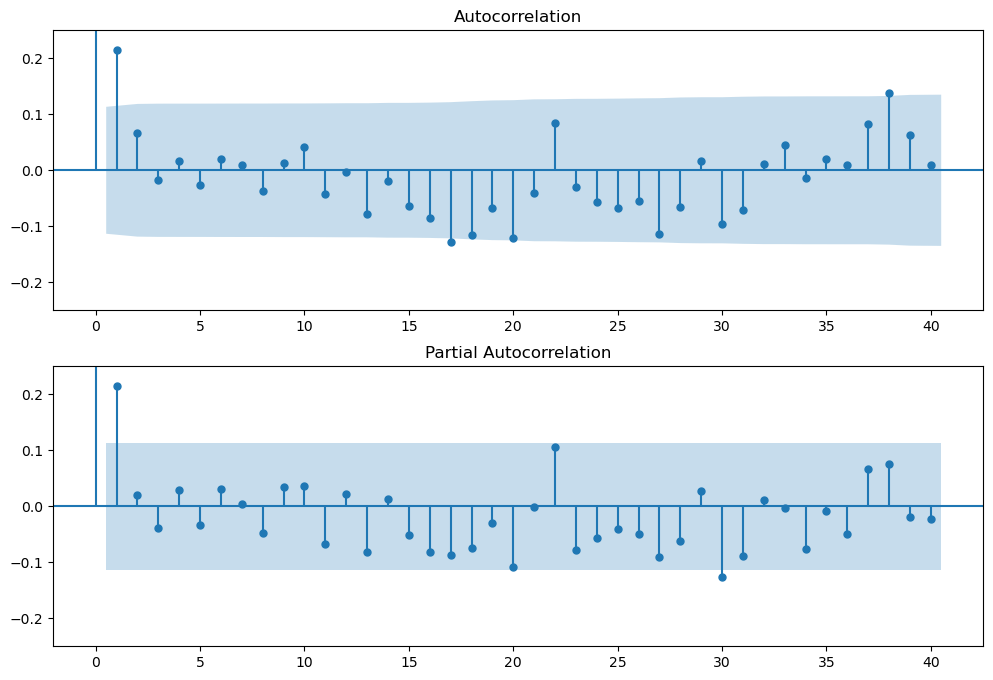

In [10]:
import statsmodels.api as sm
#bid_diff2 = bid_diff.diff().dropna()
#bid_diff3 = bid_diff2.diff().dropna()
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(bid_diff,lags=40,ax=ax1)
ax1.set_ylim(-0.25, 0.25)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(bid_diff,lags=40,ax=ax2)
ax2.set_ylim(-0.25, 0.25)
plt.savefig('afc_pacf.png')

In [11]:
import itertools
p = d = q = range(0, 2)  
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 17) for x in list(itertools.product(p, d, q))]  

best_aic = float("inf")
best_pdq = None
best_seasonal_pdq = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(bid,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=True,
                                            enforce_invertibility=True)
            results = mod.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            continue

print("Best SARIMAX model parameters - AIC:", best_aic)
print("p,d,q:", best_pdq)
print("P,D,Q,Seasonal Period:", best_seasonal_pdq)

/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.15616D+00    |proj g|=  1.77636D-10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   1.776D-10   7.156D+00
  F =   7.1561604634065388     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.8

/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  4.87816D+00    |proj g|=  2.07953D-02

At iterate   20    f=  4.82998D+00    |proj g|=  1.13237D-01

At iterate   25    f=  4.77017D+00    |proj g|=  2.69830D-02

At iterate   30    f=  4.75902D+00    |proj g|=  1.17852D-03

At iterate   35    f=  4.75738D+00    |proj g|=  1.53235D-03
  ys=-4.118E-04  -gs= 1.636E-04 BFGS update SKIPPED
  ys=-7.334E-04  -gs= 2.007E-04 BFGS update SKIPPED

At iterate   40    f=  4.75699D+00    |proj g|=  3.36602D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     44     89      2     2     0   6.528D-06   4.757D+00
  F =   4.7569773295966549     

CONVERGE


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
 This problem is unconstr

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.41999D+00    |proj g|=  1.37746D-02

At iterate    5    f=  4.41958D+00    |proj g|=  2.59387D-03

At iterate   10    f=  4.41948D+00    |proj g|=  1.70770D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     10     12      1     0     0   1.708D-06   4.419D+00
  F =   4.4194786586331327     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10



/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:47


At iterate   10    f=  6.23928D+00    |proj g|=  5.26978D-01

At iterate   15    f=  6.02901D+00    |proj g|=  3.45218D-02

At iterate   20    f=  6.01202D+00    |proj g|=  1.67224D-03

At iterate   25    f=  6.01074D+00    |proj g|=  1.07187D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     40      1     0     0   8.994D-06   6.011D+00
  F =   6.0106114685162133     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iter

/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:47

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.45811D+00    |proj g|=  4.67803D-01

At iterate    5    f=  4.19710D+00    |proj g|=  6.18324D-02

At iterate   10    f=  3.89514D+00    |proj g|=  2.14707D-02

At iterate   15    f=  3.89100D+00    |proj g|=  5.47217D-04

At iterate   20    f=  3.89052D+00    |proj g|=  8.63420D-04

At iterate   25    f=  3.89047D+00    |proj g|=  6.96822D-05

At iterate   30    f=  3.89046D+00    |proj g|=  7.81263D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.79421D+00    |proj g|=  1.23948D-02

At iterate    5    f=  5.31107D+00    |proj g|=  2.78549D-01

At iterate   10    f=  5.18780D+00    |proj g|=  4.30709D-03

At iterate   15    f=  5.18617D+00    |proj g|=  5.57798D-04

At iterate   20    f=  4.66046D+00    |proj g|=  1.71101D-02

At iterate   25    f=  4.60996D+00    |proj g|=  1.29112D-02

At iterate   30    f=  4.60862D+00    |proj g|=  3.85612D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   10    f=  6.48578D+00    |proj g|=  2.67678D-03
  ys=-8.833E-03  -gs= 8.341E-03 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     37      1     1     0   2.204D-03   6.486D+00
  F =   6.4857801124970589     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.47635D+00    |proj g|=  5.07438D-01

At iterate    5    f=  4.25440D+00    |proj g|=  4.58512D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   10    f=  3.99163D+00    |proj g|=  2.64866D-02

At iterate   15    f=  3.98175D+00    |proj g|=  2.41616D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     24      1     0     0   5.979D-06   3.982D+00
  F =   3.9817540201452446     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.47048D+00    |proj g|=  4.75633D-01


/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  4.24955D+00    |proj g|=  2.36093D-02

At iterate   10    f=  4.11210D+00    |proj g|=  2.02489D-02

At iterate   15    f=  3.93552D+00    |proj g|=  1.00284D-01

At iterate   20    f=  3.83869D+00    |proj g|=  8.09063D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     46      1     0     0   1.144D-06   3.838D+00
  F =   3.8384582561864460     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.42583D+00    |proj g|=  4.43476D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   5.684D-08   3.426D+00
  F =   3.4258308247852618     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.4

/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.45442D+00    |proj g|=  9.69347D-03

At iterate    5    f=  3.45421D+00    |proj g|=  8.93908D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6      9      1     0     0   4.091D-06   3.454D+00
  F =   3.4542052597188548     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  3.30392D+00    |proj g|=  8.31608D-03

At iterate   10    f=  3.30387D+00    |proj g|=  7.96751D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     16      1     0     0   7.491D-07   3.304D+00
  F =   3.3038640402738224     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.40446D+00    |proj g|=  1.30034D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      7      1     0     0   6.774D-07   3.404D+00
  F =   3.4043835041373582     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.3

/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py


At iterate    5    f=  3.39981D+00    |proj g|=  2.46723D-02

At iterate   10    f=  3.39845D+00    |proj g|=  2.33895D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     15      1     0     0   2.324D-06   3.398D+00
  F =   3.3984525994981647     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46446D+00    |proj g|=  6.79100D-02

At iterate    5    f=  3.43717D+00    |proj g|=  4.44741D-02

At iter

/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.41298D+00    |proj g|=  6.60196D-02

At iterate    5    f=  3.28547D+00    |proj g|=  6.76894D-02

At iterate   10    f=  3.28276D+00    |proj g|=  3.39769D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     14      1     0     0   3.398D-05   3.283D+00
  F =   3.2827610929626387     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.42440D+00    |proj g|=  4.00884D-02

At iterate    5    f=  3.32026D+00    |proj g|=  1.99303D-03

At iterate   10    f=  3.31921D+00    |proj g|=  3.60156D-04

At iterate   15    f=  3.31909D+00    |proj g|=  2.09138D-05

At iterate   20    f=  3.31908D+00    |proj g|=  3.99163D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     25      1     0     0   9.290D-06   3.319D+00
  F =   3.3190791793948762     

CONVERG

/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     27      1     0     0   4.580D-06   3.440D+00
  F =   3.4404044842973431     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.44900D+00    |proj g|=  6.75179D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.51113D+00    |proj g|=  7.19230D-02

At iterate    5    f=  3.31211D+00    |proj g|=  7.01353D-02

At iterate   10    f=  3.30896D+00    |proj g|=  3.11055D-04

At iterate   15    f=  3.30892D+00    |proj g|=  1.60080D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     22      1     0     0   2.458D-05   3.309D+00
  F =   3.3089150099252156     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.42773D+00    |proj g|=  2.00758D-02

At iterate    5    f=  3.42754D+00    |proj g|=  8.62804D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   8.207D-06   3.428D+00
  F =   3.4275397344338518     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  3.42683D+00    |proj g|=  3.71201D-02

At iterate   15    f=  3.42214D+00    |proj g|=  2.87799D-05

At iterate   20    f=  3.42214D+00    |proj g|=  5.33981D-04

At iterate   25    f=  3.42210D+00    |proj g|=  6.72300D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     45      1     0     0   3.490D-06   3.422D+00
  F =   3.4221008132359279     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  3.42764D+00    |proj g|=  7.97040D-03

At iterate   15    f=  3.42751D+00    |proj g|=  2.83394D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     18      1     0     0   3.273D-05   3.428D+00
  F =   3.4275116239348788     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.48026D+00    |proj g|=  8.11218D-02

At iterate    5    f=  3.44724D+00    |proj g|=  2.88680D-02


/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  3.43445D+00    |proj g|=  1.00877D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     13      1     0     0   1.582D-05   3.434D+00
  F =   3.4344484362499847     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.49339D+00    |proj g|=  8.76995D-02

At iterate    5    f=  3.35663D+00    |proj g|=  3.98401D-02

At iterate   10    f=  3.28386D+00    |proj g|=  3.62158D-03

At iter

/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.58128D+00    |proj g|=  6.63925D-04

At iterate    5    f=  3.58128D+00    |proj g|=  6.30906D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     10      1     0     0   1.000D-06   3.581D+00
  F =   3.5812790408442985     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.39807D+00    |proj g|=  3.36067D-02

At iterate    5    f=  3.39728D+00    |proj g|=  1.86104D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     11      1     0     0   5.099D-07   3.397D+00
  F =   3.3972778482160995     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.28296D+00    |proj g|=  5.68135D-02

At iterate   10    f=  3.28058D+00    |proj g|=  3.68625D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     14      1     0     0   2.974D-05   3.281D+00
  F =   3.2805832586704802     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
 This pro

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.40208D+00    |proj g|=  5.67442D-03

At iterate    5    f=  3.40206D+00    |proj g|=  1.43837D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     21      1     0     0   1.766D-05   3.402D+00
  F =   3.4020551680950386     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.39796D+00    |proj g|=  3.39825D-02

At iterate    5    f=  3.39724D+00    |proj g|=  3.51703D-03

At iterate   10    f=  3.39720D+00    |proj g|=  1.11095D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     14      1     0     0   5.219D-06   3.397D+00
  F =   3.3972009069824272     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     15      1     0     0   5.081D-06   3.433D+00
  F =   3.4334893108355451     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.40790D+00    |proj g|=  6.55558D-02


 This problem is unconstrained.



At iterate    5    f=  3.28171D+00    |proj g|=  3.46983D-02

At iterate   10    f=  3.28051D+00    |proj g|=  4.30630D-03

At iterate   15    f=  3.28046D+00    |proj g|=  2.37244D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     19      1     0     0   2.372D-05   3.280D+00
  F =   3.2804635338466386     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best SARIMAX model parameters - AIC: 1976.3499552022881
p,d,q: (1, 1, 0)
P,D,Q,Seasonal Period: (1, 1, 1, 17)


In [ ]:
# mod1 = SARIMAX(bid_diff, order=(1, 1, 1), seasonal_order=(1, 1, 1, 17))
# results1 = mod1.fit()
# mod2 = SARIMAX(bid_diff, order=(2, 1, 1), seasonal_order=(1, 1, 1, 17))
# results2 = mod2.fit()
# mod3 = SARIMAX(bid_diff, order=(1, 1, 2), seasonal_order=(1, 1, 1, 17))
# results3 = mod3.fit()
# values = [[results1.aic,results1.bic,results1.hqic],
#           [results2.aic,results2.bic,results2.hqic],
#           [results3.aic,results3.bic,results3.hqic]]

/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.40924D+00    |proj g|=  6.54086D-02

At iterate    5    f=  3.28296D+00    |proj g|=  5.68135D-02

At iterate   10    f=  3.28058D+00    |proj g|=  3.68625D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     14      1     0     0   2.974D-05   3.281D+00
  F =   3.2805832586704802     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

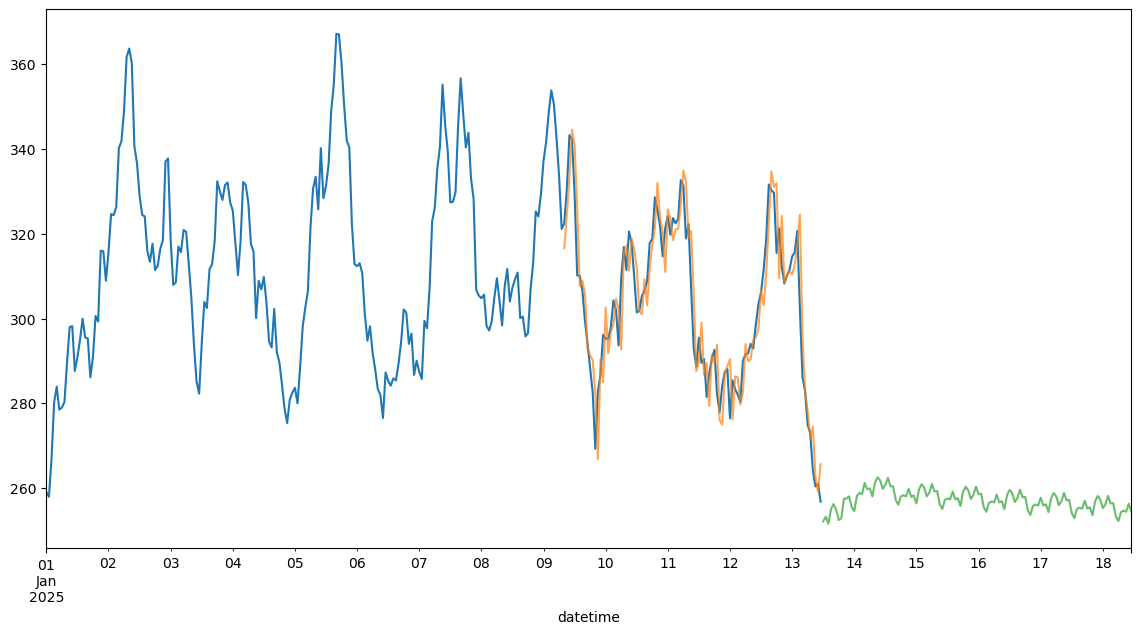

In [14]:
# Fit a SARIMAX model
# (1, 0, 1) are the AR, Differencing, and MA orders for the non-seasonal component
# (1, 1, 1, 12) are the seasonal AR, Differencing, and MA orders and seasonal period
model = SARIMAX(bid.Price, order=(1, 1, 0), seasonal_order=(1, 1, 1, 17))
results = model.fit()

# Make in-sample prediction and forecast
prediction = results.get_prediction(start=200, dynamic=False)
predicted_mean = prediction.predicted_mean
forecast = results.get_forecast(steps=120)
forecast_mean = forecast.predicted_mean

start_date = '2025-02-01 00:00:00'
# Plot the results
plt.figure(figsize=(14, 7))
#.loc[start_date:]
bid['Price'].plot(label='Observed')
predicted_mean.plot(label='In-sample Prediction', alpha=0.7)
forecast_mean.plot(label='Forecast', alpha=0.7)
plt.fill_between(forecast_mean.loc[start_date:].index,
                 forecast.conf_int().iloc[:, 0],
                 forecast.conf_int().iloc[:, 1], color='k', alpha=0.1)
plt.title('SARIMAX Model - Time Series Forecast')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
#plt.ylim(100, 180)
plt.show()

  

print(results.summary())


/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


Test RMSE: 6.67


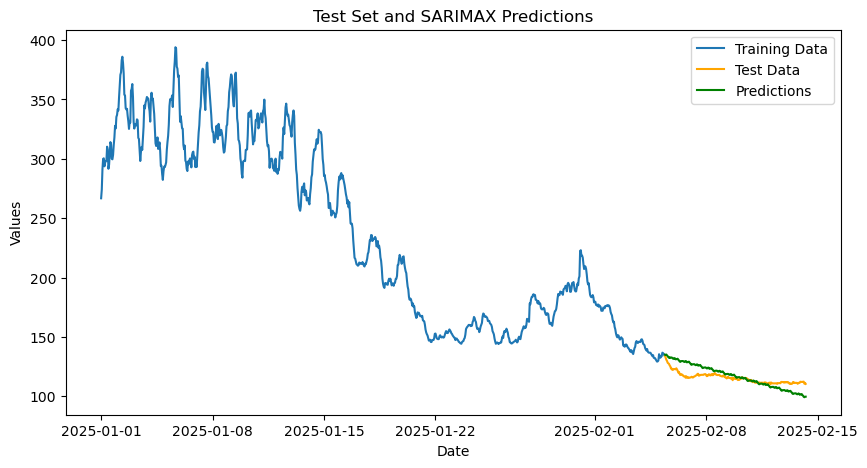

2025-02-05 10:00:00    134.958636
2025-02-05 11:00:00    134.815213
2025-02-05 12:00:00    135.153222
2025-02-05 13:00:00    134.345741
2025-02-05 14:00:00    133.791349
                          ...    
2025-02-14 02:00:00    100.490878
2025-02-14 03:00:00     99.586305
2025-02-14 04:00:00     99.180140
2025-02-14 05:00:00     99.608748
2025-02-14 06:00:00     99.648836
Freq: H, Name: predicted_mean, Length: 213, dtype: float64


In [10]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

train_data, test_data = train_test_split(bid, test_size=0.2, shuffle=False)

sarimax_model2 = SARIMAX(train_data, order=(2, 1, 1), seasonal_order=(2, 1, 1, 17))
sarimax_result2 = sarimax_model2.fit(disp=False)

predictions2 = sarimax_result2.get_forecast(steps=len(test_data)).predicted_mean

rmse = np.sqrt(mean_squared_error(test_data, predictions2))

print(f'Test RMSE: {rmse:.2f}')

plt.figure(figsize=(10, 5))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Test Data', color='orange')
plt.plot(test_data.index, predictions2, label='Predictions', color='green')
plt.title('Test Set and SARIMAX Predictions')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()
print(predictions2)
predictions2.to_csv('sarima_pred_bid.csv')

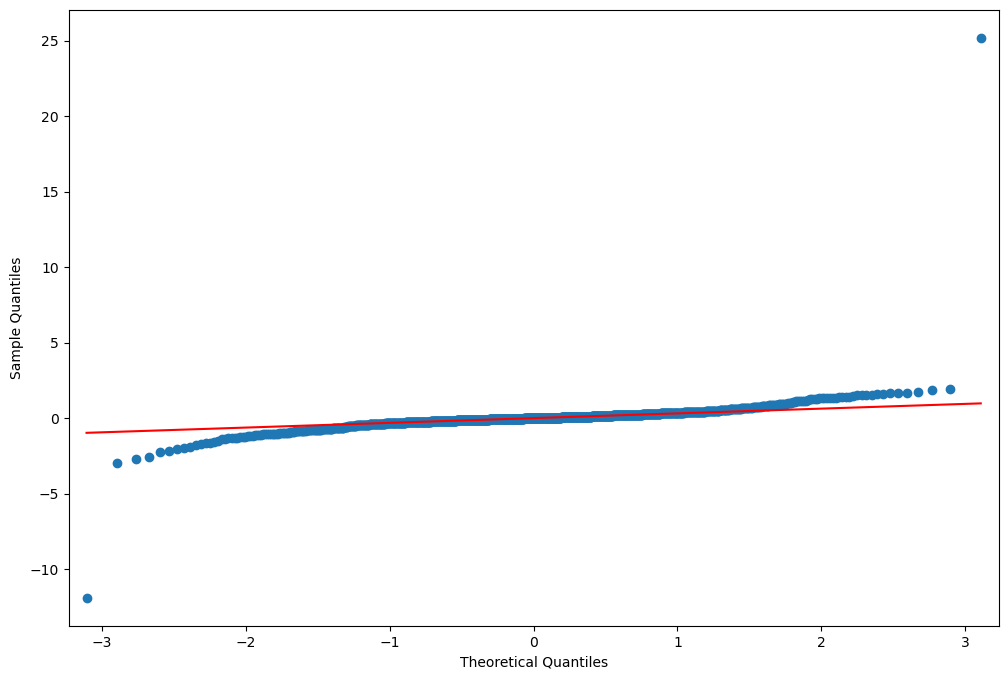

In [10]:
from statsmodels.graphics.api import qqplot
resid = results.resid
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(resid, line='q', ax=ax, fit=True)
fig.savefig('sarimaqq.png')

In [6]:
from sklearn.metrics import mean_squared_error
predicted_values = results.get_prediction().predicted_mean

# 计算均方误差
mse = mean_squared_error(bid['Price'], predicted_values)
print('Mean Squared Error (MSE) for in-sample prediction:', mse)

NameError: name 'results' is not defined

In [ ]:
#index for TEMA
pred['EMA1'] = pred['Price'].ewm(span=span, adjust=False).mean()
pred['EMA2'] = pred['EMA1'].ewm(span=span, adjust=False).mean()
pred['EMA3'] = pred['EMA2'].ewm(span=span, adjust=False).mean()

#index for P-MA
pred['SMA_50'] = pred['Close'].rolling(window=50).mean()  #50h of SMA
#set trading signals
pred['Signal'] = 0
pred['Signal'][pred['Close'] > pred['SMA_50']] = 1  
pred['Signal'][pred['Close'] < pred['SMA_50']] = -1 
pred['Positions'] = pred['Signal'].diff()  # trading strategy e.g. trade when signal changes